In [50]:
# implementing bayesian statistics on dataset phd-delays.csv

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import arviz as az
import sklearn as sk
import warnings
warnings.filterwarnings('ignore')

In [51]:
# reading the dataset
df = pd.read_csv('phd-delays.csv', delimiter=';')
df.columns = ['B3_difference_extra','E4_having_child','E21_sex','E22_Age','E22_Age_Squared']

def standardize(series):
    """Standardize a pandas series"""
    return (series - series.mean()) / series.std()

standardize(df['B3_difference_extra'])
standardize(df['E22_Age'])
standardize(df['E22_Age_Squared'])
#split the dataset
X = df[['E22_Age','E22_Age_Squared']]
y = df['B3_difference_extra']
import sklearn.model_selection as skm
X_train, X_test, y_train, y_test = skm.train_test_split(X, y, test_size=0.2, random_state=42)
y_ = y_train
y_train = y
X_ = X_train
X_train = X


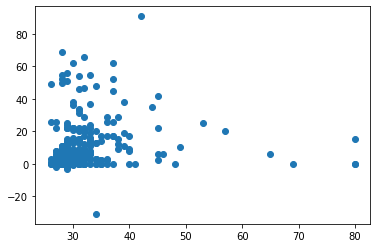

In [52]:
# visualise data
plt.scatter(X['E22_Age'],y)
plt.show()

In [53]:

# creating a model for y = b_intercept + b_0*age + b_1*age^2 + e
mu_ = 0
sd = 100
with pm.Model() as model:
    # mu_ = pm.Uniform('mean_gen' , lower = -10, upper = 20)
    b_intercept = pm.Normal('b_intercept',mu = -35, sigma=50)
    b_0 = pm.Normal('b_0' , mu = 2.5 , sigma=5)
    b_1 = pm.Normal('b_1' , mu = -0.03, sigma = 0.01)
    eps = pm.InverseGamma('eps', 0.5, 0.5)
    sg = pm.HalfNormal('sg' , sigma=1)
    likelihood = pm.Normal('y', mu=b_intercept + b_0*X_train['E22_Age'] + b_1*X_train['E22_Age_Squared']+eps, sigma=sg, observed=y_train)

    # perform inference
    trace = pm.sample(init='adapt_diag',target_accept = 0.98)
    # prior_checks = pm.sample_prior_predictive(samples = 300)



Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sg, eps, b_1, b_0, b_intercept]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 91 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


Got error No model on context stack. trying to find log_likelihood in translation.


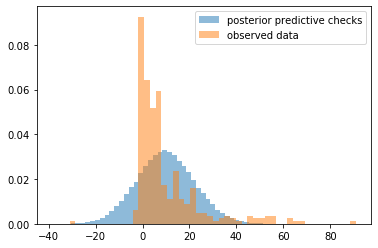

In [58]:
# pm.autocorrplot(trace, var_names=['b_intercept','b_0','b_1'])

# perform prior predictive checks on the model
with model:
    prior_checks = pm.sample_prior_predictive(samples = 300)
    posterior_checks = pm.sample_posterior_predictive(trace, samples =300)

az.summary(trace)
# compare posterior predictive with observed data
# y_pred = trace[:2000].get_values('y')

# histo of the posterior predictive
plt.hist(posterior_checks['y'].flatten(), bins=50, density=True, alpha=0.5, label='posterior predictive checks')
plt.hist(y_train, bins=50, density=True, alpha=0.5, label='observed data')
plt.legend(loc=0)
plt.show()

In [59]:
# finding MAP parameter values for the model
map_estimate = pm.find_MAP(model=model)
print(map_estimate)

# perform accuracy test on this test data with MAP parameter values

y_pred = map_estimate['b_intercept'] + map_estimate['b_0']*X_test['E22_Age'] + map_estimate['b_1']*X_test['E22_Age_Squared']+map_estimate['eps']
print(y_pred)
print(y_test)
print(sk.metrics.mean_squared_error(y_test, y_pred))



{'b_intercept': array(-35.02104073), 'b_0': array(2.07642817), 'b_1': array(-0.0201467), 'eps_log__': array(-1.10557563), 'sg_log__': array(2.45786061), 'eps': array(0.33102028), 'sg': array(11.67979714)}
25     14.556996
317     6.686599
73     11.892358
193     9.470799
57      8.583026
         ...    
258    10.318278
3      13.951276
77     10.318278
240     7.654959
60      8.583026
Length: 67, dtype: float64
25     17
317     0
73     22
193     0
57      0
       ..
258     0
3      17
77     21
240     3
60     -2
Name: B3_difference_extra, Length: 67, dtype: int64
186.6759362764698


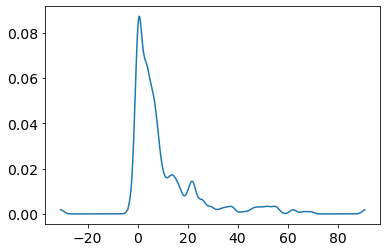

Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


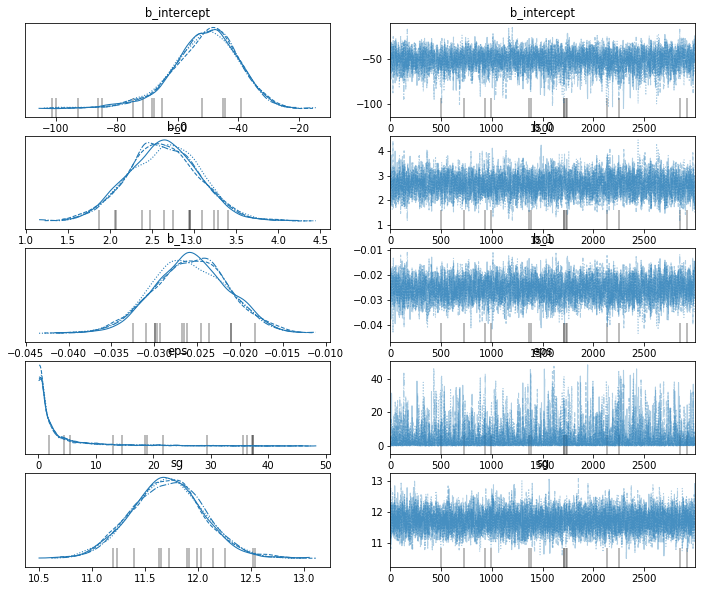

Got error No model on context stack. trying to find log_likelihood in translation.


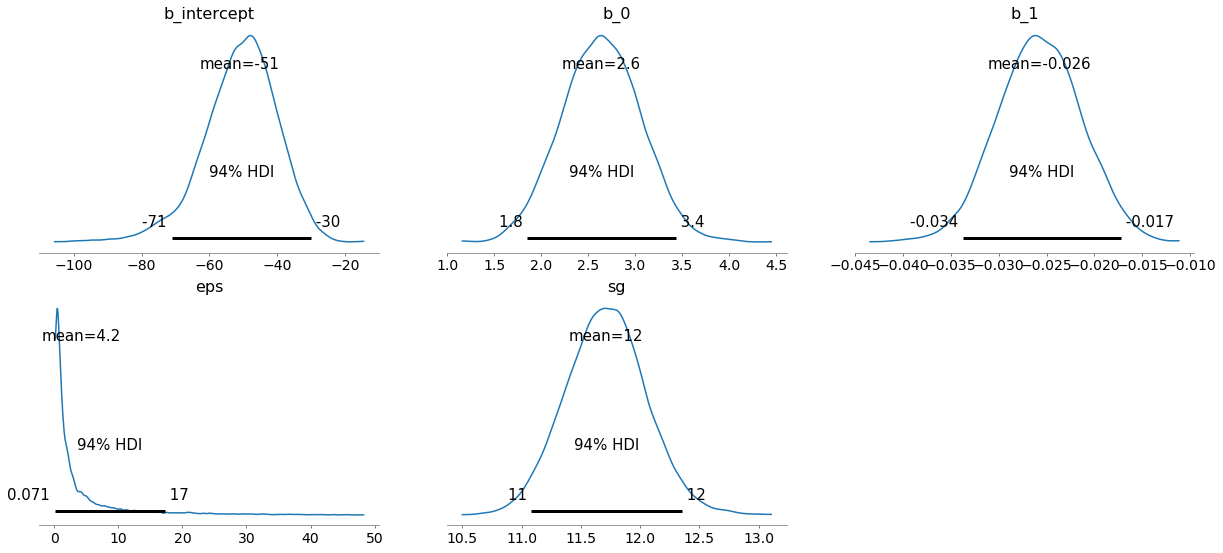

Got error No model on context stack. trying to find log_likelihood in translation.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b_intercept,-50.995,11.038,-71.106,-30.085,0.207,0.150,2950.0,3402.0,1.0
b_0,2.642,0.424,1.848,3.433,0.007,0.005,3413.0,4345.0,1.0
b_1,-0.026,0.004,-0.034,-0.017,0.000,0.000,3474.0,4715.0,1.0
eps,4.223,6.721,0.071,17.314,0.130,0.094,4191.0,3225.0,1.0
sg,11.711,0.340,11.082,12.357,0.005,0.003,5421.0,5075.0,1.0


In [60]:
# plot r_hat for all parameters
az.plot_kde(y)
plt.show()
# plots of the trace runs performed
az.plot_trace(trace)
plt.show()
az.plot_posterior(trace)
plt.show()
# az.plot_density(trace)
# plt.show()
# perform accuracy test on this test dataset
az.summary(trace) #summarise our trace run with MCMC

184.8051854108854


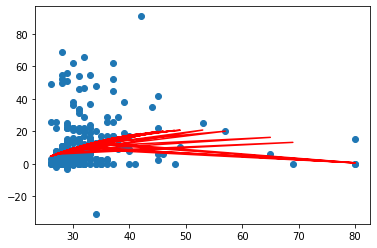

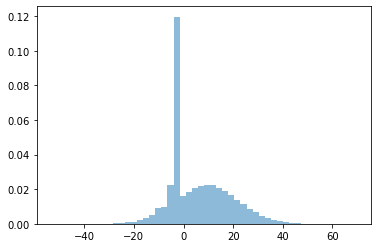

In [57]:
with model:
    ppc = az.from_pymc3(posterior_predictive=pm.sample_posterior_predictive(trace))

posterior_samples = ppc.posterior_predictive['y'].values.flatten()


# comparing with standard linear regression
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X_train, y_train)
y_pred = reg.predict(X_test)
print(sk.metrics.mean_squared_error(y_test, y_pred))

# plotting line of best fit
plt.scatter(X_train['E22_Age'],y_train)
plt.plot(X_train['E22_Age'],reg.predict(X_train),color='red')
plt.show()
plt.hist(posterior_samples, bins=50, density=True, alpha=0.5)
plt.show()